# Instrumental Noise in _Kepler_ and _K2_ #2: Spurious Signals and Time Sampling Effects

## Learning Goals

By the end of this tutorial, you will:

- Understand the causes behind various spurious signals in _Kepler_ and _K2_ data.
- Be able to identify which data products are affected by these signals.
- Be able to recognize quality issues specific to Short Cadence data.

## Introduction

This tutorial is the second part of a series on identifying instrumental and systematic sources of noise in _Kepler_ and _K2_ data. The first tutorial in this series is suggested (but not necessary) reading for working through this one. Assumed knowledge for this tutorial is a working familiarity with _Kepler_ light curve files, periodograms, and a basic understanding of aperture photometry.

## Imports

We'll use **[Lightkurve](https://docs.lightkurve.org/)** for downloading and handling _Kepler_ data throughout this tutorial. We'll also use **[NumPy](https://numpy.org/)** to handle arrays for aperture masks.

In [1]:
import lightkurve as lk
import numpy as np
%matplotlib inline

---

## 1. Background

The _Kepler_ space telescope observed the same patch of sky for four continuous years, between 2009 and 2013. Over the course of 18 observing quarters, it collected light curves and pixel data for 150,000 stars in 30-minute Long Cadence mode, and 512 stars per quarter in one-minute Short Cadence mode. Following the failure of two of the telescope's four reaction wheels, the telescope continued as the _K2_ mission, which observed along the ecliptic plane for 20 observing campaigns.

_Kepler_ and _K2_ time series data have been extensively analysed, in both the time domain and the frequency domain. In this tutorial, we'll look at spurious signals — that is, signals introduced by non-astronomical sources — in data from both missions, across simple aperture photometry (SAP) and presearch data conditioning SAP (PDCSAP), as well as in individual pixel time series from target pixel files (TPFs). Many of the effects we'll cover were corrected by the presearch data conditioning (PDC) pipeline, but are still of interest to anyone working closely with pixel data or performing custom photometry. 

## 2. Early _Kepler_ Mission Spurious Signals

As _Kepler_ data processing evolved over the course of the mission, there were issues in the first few quarters that were mitigated by various alterations to the algorithms and systems involved. In this section, we're going to look at two spurious signals that you might come across in the first year of data from the _Kepler_ mission.

### 2.1 Focus changes

Throughout the nominal _Kepler_ mission, there was a regular momentum desaturation of the reaction wheels which controlled the telescope's pointing. In Quarters 1–3, an issue with the onboard temperature controller meant that momentum desaturation events induced non-sinusoidal variations with periods on order a few hours, reflecting a heating cycle. This was fixed at the end of Quarter 3, greatly reducing the amplitude of the focus changes, to the point that they can't be seen at all in Quarters 8–13. ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.2.)

For a closer look at data quality events caused by the reaction wheels, see part one of this tutorial series, and the [_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.3.

The focus changes are corrected by the PDC pipeline, but if you're working with simple aperture photometry you might come across some spurious signals. The following code selects one pixel from a TPF and plots its SAP light curve:


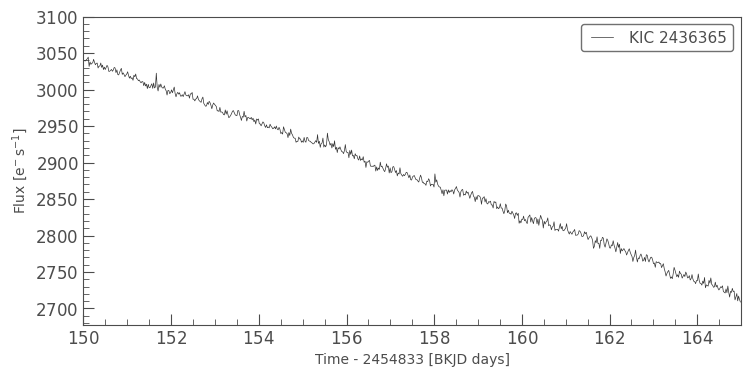

In [2]:
tpf_fc = lk.search_targetpixelfile('KIC 2436365', cadence='long', quarter=1).download()
one_pixel_mask = np.zeros((tpf_fc.shape[1], tpf_fc.shape[2]), dtype='bool')
one_pixel_mask[1,2] = True
ax = tpf_fc.to_lightcurve(aperture_mask=one_pixel_mask).plot()
ax.set_xlim(150, 165)
ax.set_ylim(ymax=3100);

Notice the jagged pattern which repeats around five times every day. This is the signal introduced by focus changes. KIC 2436365 is a non-variable star, which means that this pattern is the only variable signal present, and there is no confusion as to what we're looking at. In variable stars, this pattern could cause an effect similar to signal dilution, where actual stellar variability or transit events are attenuated by the presence of another signal.

### 2.2 Variable fine guidance stars

*Kepler*'s attitude was controlled by Fine Guidance Sensors (FGS). This involved measuring the centroids of 40 guide stars. In the early mission, the centroid measurement was dependent on the star's flux. This meant that variable guide stars could influence the signal of any star they were used to calibrate. ([*Kepler* Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 4.5.)

This issue was largely fixed after Quarter 1. Of the 40 FGS stars, only two used during Quarter 2 were variable: an intrinsic variable with a 2.9-day period, and an eclipsing binary with an 18.3-day period. These signals may be partially visible in the photometry of any target on the affected modules, in Quarters 0–2.

As an example, let's look at a star that shows a remnant of the 2.9-day period. We'll only inspect the first three quarters, as the signal is significantly diluted in the full time series.

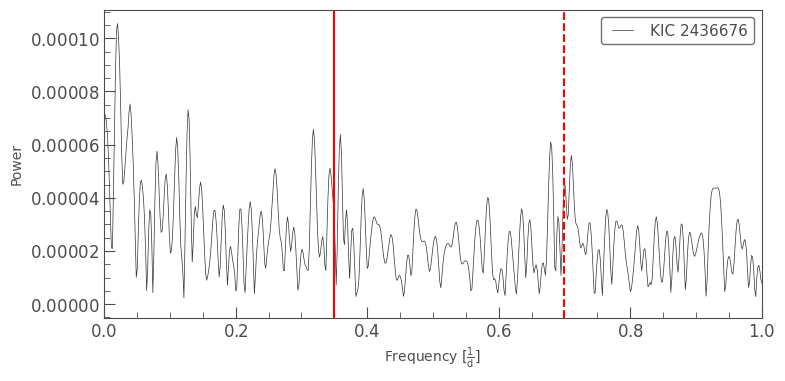

In [3]:
lc_fgs = lk.search_lightcurve('KIC 2436676', author="Kepler", quarter=[0, 1, 2]).download_all().stitch()
ax = lc_fgs.to_periodogram().plot()
ax.set_xlim(0,1)
ax.axvline(0.35, c='r')
ax.axvline(0.7, c='r', ls='--');

The signal of the variable FGS star is present around 0.35 cycles per day, and has a harmonic where you'd expect it at 0.7 c/d. Because of the way this signal is introduced into the data, it remains low amplitude, and is unlikely to have an effect on the majority of _Kepler_ analysis. In fact, when studying a star with its own strong signal, and/or all 17 quarters of data, the variable FGS signal is unlikely to show up at all.

For an accuracy check, let's look at the same region in Quarters 3 and 4, which has a comparable sampling rate in the periodogram, to show that there is no signal present:

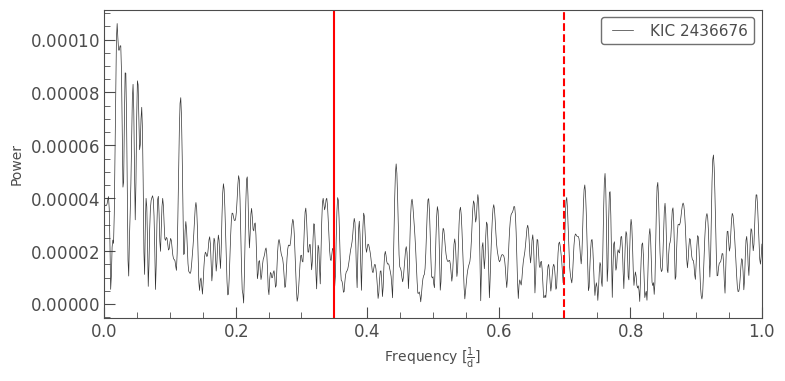

In [4]:
lc_no_fgs = lk.search_lightcurve('KIC 2436676', author="Kepler", quarter=[3,4]).download_all().stitch()
ax = lc_no_fgs.to_periodogram().plot()
ax.set_xlim(0,1)
ax.axvline(0.35, c='r')
ax.axvline(0.7, c='r', ls='--');

## 3. Variable Guide Stars in _K2_

Like *Kepler*, the *K2* mission used guide stars to assist with pointing as part of the FGS. Where *Kepler* used 40 guide stars throughout the whole mission, in *K2* it was harder to find suitable guide stars in *K2*'s visually crowded fields along the ecliptic plane, and so four stars were used in each campaign. This predictably reduced pointing stability, as each guide star in *K2* contributed more to the overall pointing.

The majority of *K2* guide stars were stable. However, one of the Campaign 6 guide stars was an eclipsing binary with a period of 0.6046 days. By [folding](https://docs.lightkurve.org/reference/api/lightkurve.lightcurve.LightCurve.html#lightkurve.lightcurve.LightCurve.fold) an affected light curve on this period, we can see the impact of the eclipsing binary on an otherwise non-variable target.

The example below is from the [*K2* Data Release Notes 35](https://archive.stsci.edu/missions/k2/doc/drn/KSCI-19156-001_K2-DRN35_C6.pdf) on the reprocessing of Campaign 6:

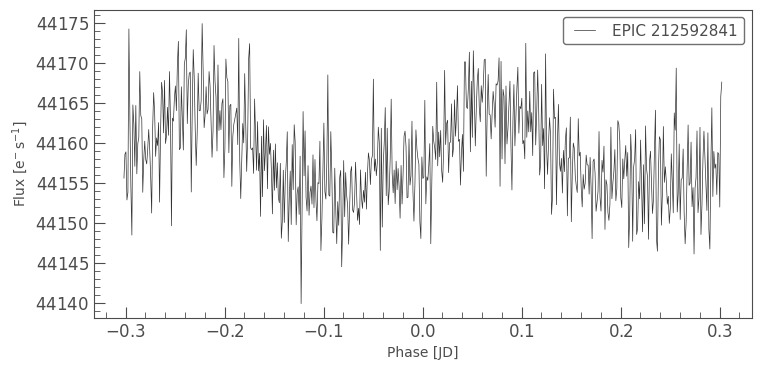

In [5]:
lc_k2gs = lk.search_lightcurve("EPIC 212592841", author="K2", campaign=6).download()
lc_k2gs.fold(period=0.6046).remove_outliers().bin(time_bin_size=0.001).plot();

## 4. PDC Long Period Attenuation

The _Kepler_ PDC pipeline is designed to prepare data for planet searches, which is focused on short-period transit signals; long-period signals are often instrumental systematics, such as flux variations caused by pixel-level temperature changes. To remove these systematics, the pipeline corrects variability with a period of roughly 10 days or more — or a frequency of less than 0.1 c/d ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.15). Of course, this also results in the loss of any long-period stellar variability. As such, it is suggested that you perform your own photometry, such as outlined in the custom aperture photometry tutorial, if you're searching for long periods.

The star we'll use as an example was studied by [Yu et al. 2020](https://arxiv.org/pdf/2001.10878.pdf); this paper also includes a brief discussion of the attenuation of long-period signals in PDCSAP data.

Let's look at the PDC data first:

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

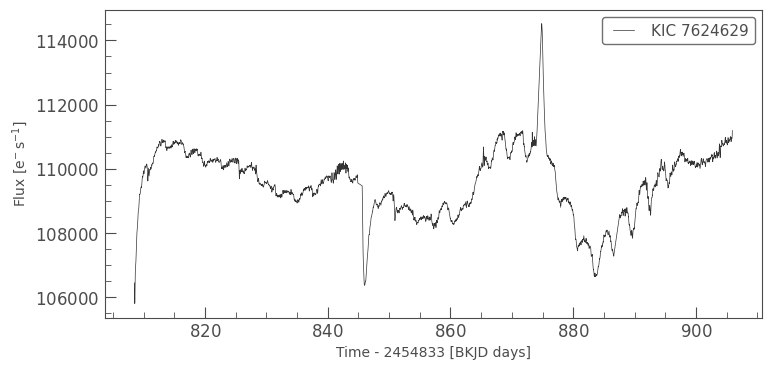

In [6]:
lc_pdca = lk.search_lightcurve("KIC 7624629", author="Kepler", quarter=9).download()
lc_pdca.plot()

As you can see, there looks to be some periodicity of around four days in this star; there are also massive spikes and a strange-looking long-period trend. This is the result of overcorrection by the PDC pipeline. When we look at the SAP flux, we can see the true long-period trend present in this star:

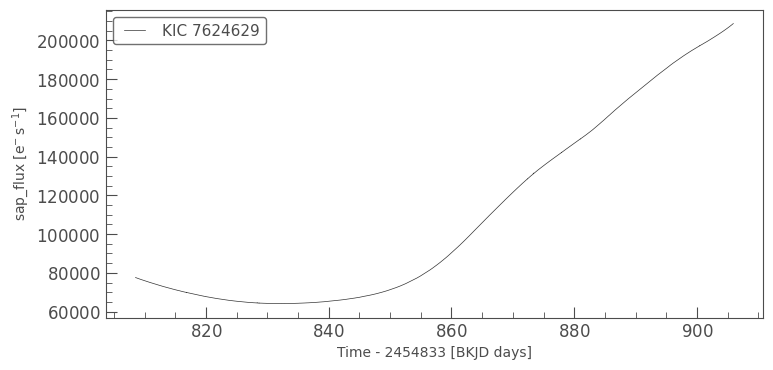

In [7]:
lc_pdca.plot(column="sap_flux");

This looks like a smooth curve, but that's because this is such high amplitude variation; note the scale of the y-axis. Zooming in reveals a noisier curve, though small-scale structure is generally of less interest when studying such stars.

## 5. Short Cadence Issues

The spurious signals that we've looked at so far have been in Long Cadence _Kepler_ data. These signals can also be found in Short Cadence data; however, there are two further time sampling effects that are unique to Short Cadence data, which we will explore in the following section. We'll also look at one Short Cadence effect unique to _K2_ data.

### 5.1 Requantization gaps

As part of onboard data compression, Short Cadence data for stars at fluxes brighter than 20,000 $\rm{e^{-}s^{-1}}$ is *requantized*, meaning the flux measurements settle into "bands" at preferred values. This phenomenon can be seen in single-pixel time series, but averages out over multiple pixels when performing simple aperture photometry.

This star, KIC 11182716, is shown in the [_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.10. It has a _Kepler_ magnitude of Kp = 11.994, which puts it at the lower end of stars that saturate the detector. The code below extracts the time series for one bright pixel and plots the light curve as a series of dots to show the requantization bands:

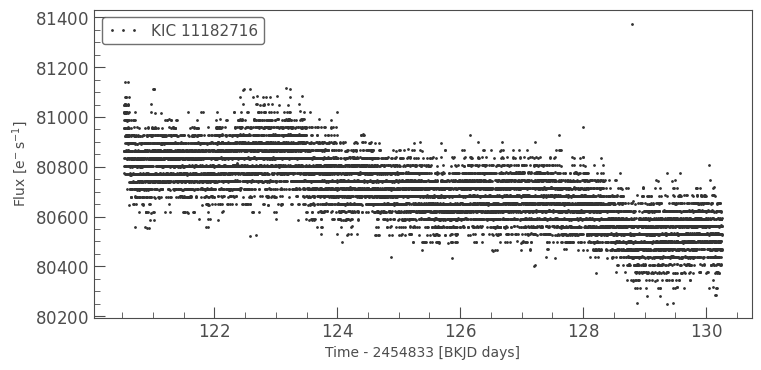

In [8]:
tpf_scrq = lk.search_targetpixelfile('KIC 11182716', cadence='short', quarter=0).download()
one_pixel_mask = np.zeros((tpf_scrq.shape[1],tpf_scrq.shape[2]), dtype='bool')
one_pixel_mask[4,4] = True
lc_scrq = tpf_scrq.to_lightcurve(aperture_mask=one_pixel_mask)
lc_scrq.plot(marker='.', linewidth=0);

### 5.2 Nyquist alias spurious frequencies

The PDC pipeline uses [cotrending basis vectors](https://keplerscience.arc.nasa.gov/data-products.html#cotrending-basis-vectors-cbvs) (CBVs) to correct both Long and Short Cadence data. However, as the CBVs are created based on Long Cadence data, they cannot correct for spurious signals above the Long Cadence Nyquist frequency, 283$\mu$Hz (24 c/d).

The most prominent of these spurious frequencies is the Long Cadence sampling rate, introduced by onboard electronics ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.11). This frequency (566.4$\mu$Hz, or 48.94 c/d) and integer multiples show up throughout Short Cadence data. In the plot below, we've marked 48.94 c/d and its first eight multiples with arrows:

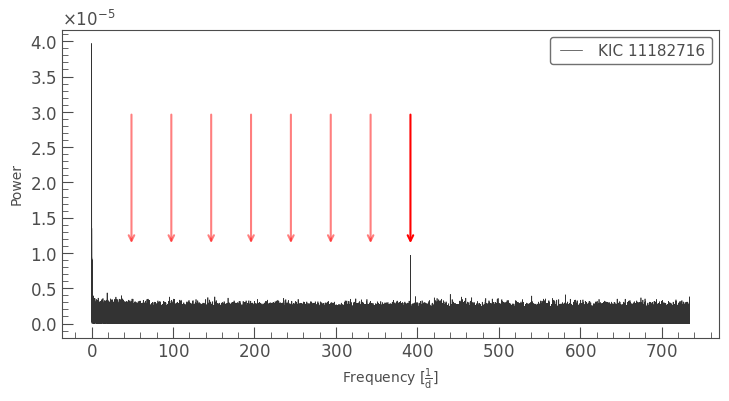

In [9]:
lc_scsf = lk.search_lightcurve('KIC 11182716', author="Kepler", cadence='short').download_all().stitch()
ax = lc_scsf.remove_outliers().to_periodogram().plot()

for i in range(8):
  i+=1 
  if i == 8:
    ax.annotate('', xy=(i*48.94, 1.1e-5), xytext=(i*48.94, 3e-5), arrowprops=dict(arrowstyle='->', color='r', linewidth=1.5))
  else:
    ax.annotate('', xy=(i*48.94, 1.1e-5), xytext=(i*48.94, 3e-5), arrowprops=dict(arrowstyle='->', color='r', linewidth=1.5, alpha=0.5))

More multiples of this frequency show up in fainter stars. We can begin to see this in KIC 2303576, which has a _Kepler_ magnitude of Kp = 17.445, and shows both the eighth and ninth multiples of the Long Cadence sampling rate:

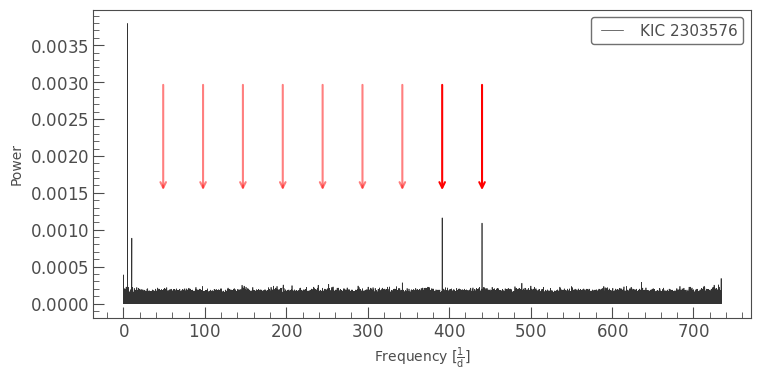

In [10]:
lc_scsf = lk.search_lightcurve('KIC 2303576', author="Kepler", cadence='short').download_all().stitch()
ax = lc_scsf.remove_outliers().to_periodogram().plot()

for i in range(9):
  i+=1 
  if i == 8 or i ==9:
    ax.annotate('', xy=(i*48.94, 0.0015), xytext=(i*48.94, 0.003), arrowprops=dict(arrowstyle='->', color='r', linewidth=1.5))
  else:
    ax.annotate('', xy=(i*48.94, 0.0015), xytext=(i*48.94, 0.003), arrowprops=dict(arrowstyle='->', color='r', linewidth=1.5, alpha=0.5))

A list of other spurious frequencies present in Short Cadence data can be found in Table 5 of the [_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf).

### 5.3 _K2_ Short Cadence data

All _K2_ data is affected by the six-hour thruster firings to correct for pointing drift. The PDCSAP pipeline uses CBVs to remove this effect in Long Cadence data. As with _Kepler_ Short Cadence data, applying these same corrections to Short Cadence data leaves some systematics intact. _K2_ Short Cadence data is subject to the two issues noted above, as well as further spurious frequencies introduced by the six-hour drift.

The following example is taken from the [_K2_ Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19116-002.pdf). First, let's download some data for our star, EPIC 211414081, and see what the SAP data looks like. Again, we're using some extra arguments with our plotting function to display the light curve as individual points, which makes the scale of the outliers clearer.

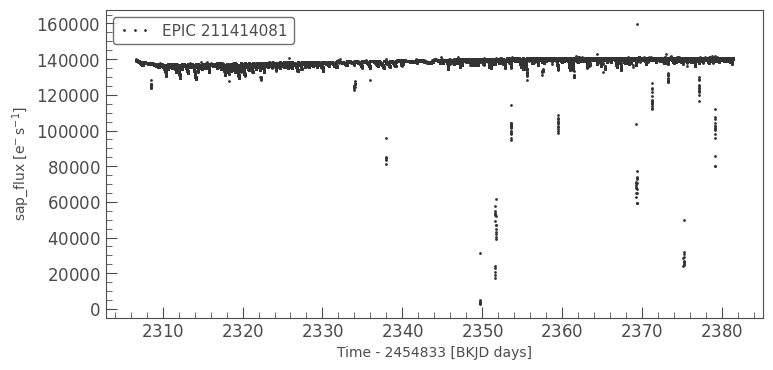

In [11]:
lc_k2 = lk.search_lightcurve('EPIC 211414081', author="K2", cadence='short', campaign=5).download()
lc_k2.plot(column='sap_flux', marker='.', linewidth=0);

The PDCSAP time series for this target shows the effect of the six-hour systematics as regular spikes and occasional dramatic outliers:

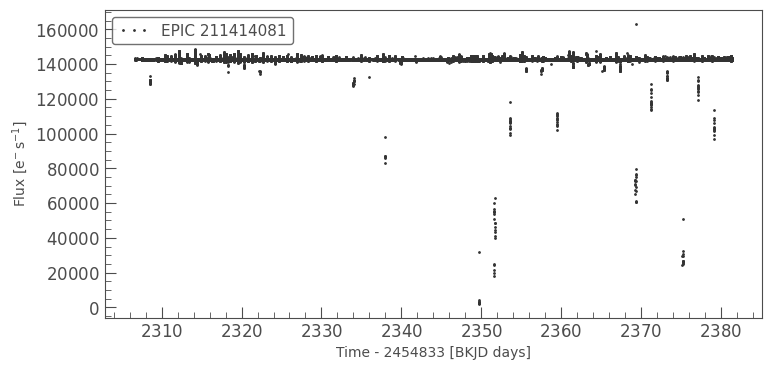

In [12]:
lc_k2.plot(marker='.', linewidth=0);

The [_K2_ Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19116-002.pdf) cautions that no detrending method can 100% remove the effects of thruster firing, even in Long Cadence data. However, as Short Cadence data are harder to correct than Long Cadence, some Short Cadence targets may be better suited to custom aperture photometry than using PDCSAP.

Let's look at how this manifests in a periodogram:

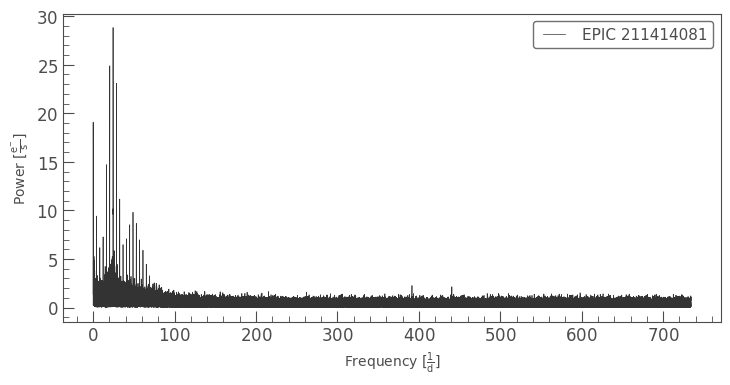

In [13]:
lc_k2.remove_outliers().to_periodogram().plot();

We can see a series of high-amplitude spikes at four cycles/day, or a six-hour period. Two harmonics of the Long Cadence sampling frequency are also present, as above. Comparing the scale of these two sets of spurious frequencies, we can see the negative impact of the six-hour drift on _K2_ Short Cadence data.

As some remnant of the six-hour drift will always remain in _K2_ data, these signals may appear in Long Cadence data too, but not to the same extent. When working with Short Cadence data, a complementary approach to custom aperture photometry could be manual periodogram cleaning, using software such as [Period04](https://www.univie.ac.at/tops/Period04/). However, only the lower frequencies are impacted here, which luckily does not interfere with the Short Cadence advantage over Long Cadence: its ability to probe higher frequencies. 

## About this Notebook

**Author:** [Isabel Colman](http://orcid.org/0000-0001-8196-516X) (`isabel.colman@sydney.edu.au`)  

**Updated on:** 2020-09-29


## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [14]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>